In [1]:
# It will train a Gaussian denoiser on simulated Gaussian noise on the ground truth, rather than usin the noisy data from the data loader.
# This exploits the idea that a simple Gaussian denoiser can be extrapolated to other applications, such as CT reconstruction.
# Ideally you want to use this denoiser as a prox operator or a regularizer in an iterative reconstruction algorithm.

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Standard imports
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

# Torch imports
import torch

import deepinv

# Lion imports
from LION.classical_algorithms.fdk import fdk
from LION.experiments import ct_experiments
from LION.reconstructors.PnP import PnP

/home/t/miniconda3/envs/lion_proposed/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# % Chose device:
device = torch.device("cuda:0")
torch.cuda.set_device(device)

# Make reproducible
torch.manual_seed(0)
torch.use_deterministic_algorithms(True)
torch.backends.cudnn.deterministic = True

In [5]:
experiment = ct_experiments.LowDoseCTRecon(dataset="LIDC-IDRI")
lidc_dataset = experiment.get_training_dataset()

Preparing patient list, this may take time....
Patient lists ready for train dataset


In [6]:
def my_ssim(x: torch.Tensor, y: torch.Tensor) -> float:
    x = x.cpu().numpy().squeeze()
    y = y.cpu().numpy().squeeze()
    return ssim(x, y, data_range=x.max() - x.min())


# Test
denoiser = deepinv.models.DRUNet(pretrained="download", device=device)
sigma = 25 / 255  # noise level for denoiser

def denoiser_fn_admm(x: torch.Tensor) -> torch.Tensor:
    with torch.no_grad():
        x = x.repeat(1, 3, 1, 1)  # grayscale 2D to 4-channel batch
        denoised = denoiser(x, sigma=sigma)
        denoised = torch.mean(denoised, dim=1)  # average the channels to get grayscale
    return denoised


reconstructor = PnP(experiment.geometry, denoiser=denoiser_fn_admm, algorithm="ADMM")

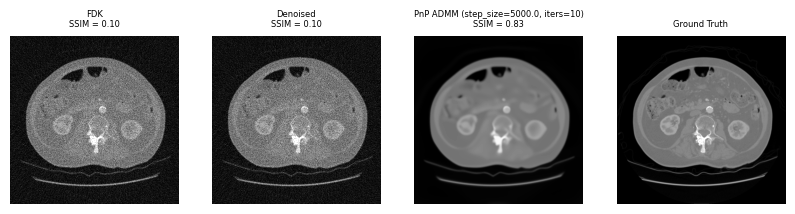

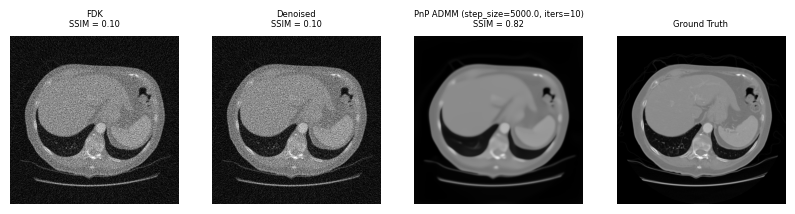

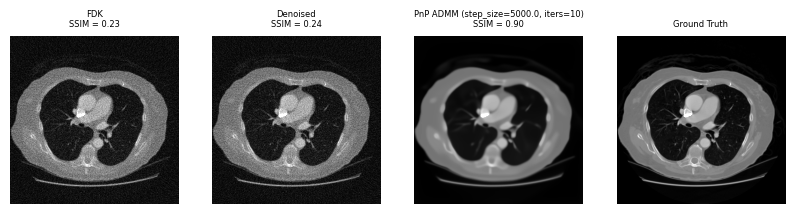

In [7]:
admm_iterations = 10
admm_step_size = 5e3  # TODO: Tune step size?

for i, (sino, target) in enumerate(lidc_dataset):
    if i >= 3:
        break
    sino = sino.unsqueeze(0)  # Add batch dimension
    target = target.unsqueeze(0)  # Add batch dimension

    sino = sino.to(device)
    target = target.to(device)
    recon = fdk(sino, op=experiment.geometry)

    denoised = denoiser_fn_admm(recon.clone()).unsqueeze(0)

    # PnP reconstruction
    pnp_admm_result = reconstructor.admm_algorithm(
        sino.squeeze(0),
        eta=admm_step_size,
        max_iter=admm_iterations,
        cg_max_iter=100,
        cg_tol=1e-7,
    ).unsqueeze(0)

    n_subplots = 4
    plt.figure(figsize=(n_subplots * 2.5, 2.5))

    plt.subplot(1, n_subplots, 1)
    plt.imshow(recon[0, 0].cpu(), cmap="gray")
    plt.clim(0, 2)
    plt.axis("off")
    plt.title(
        "FDK" + "\nSSIM = {:.2f}".format(my_ssim(target[0], recon[0])), fontsize=6
    )

    plt.subplot(1, n_subplots, 2)
    plt.imshow(denoised[0, 0].cpu(), cmap="gray")
    plt.clim(0, 2)
    plt.axis("off")
    plt.title(
        "Denoised" + "\nSSIM = {:.2f}".format(my_ssim(target[0], denoised[0])),
        fontsize=6,
    )

    plt.subplot(1, n_subplots, 3)
    plt.imshow(pnp_admm_result[0, 0].cpu(), cmap="gray")
    plt.title(
        f"PnP ADMM (step_size={admm_step_size}, iters={admm_iterations})"
        + "\nSSIM = {:.2f}".format(my_ssim(target[0], pnp_admm_result[0])),
        fontsize=6,
    )
    plt.clim(0, 2)
    plt.axis("off")

    plt.subplot(1, n_subplots, n_subplots)
    plt.imshow(target[0, 0].cpu(), cmap="gray")
    plt.title("Ground Truth", fontsize=6)
    plt.axis("off")
    plt.clim(0, 2)

    plt.savefig(
        f"test_{i}--admm_stepsize{admm_step_size:.2e}_iters{admm_iterations}.png",
        bbox_inches="tight",
        dpi=300,
    )
    plt.show()
# exit()